In [92]:
# Importing library
import pandas as pd

In [93]:
# Loading the datasets from local files
customers = pd.read_csv(r"C:\Users\Windows 10\Downloads\Customers.csv")
products = pd.read_csv(r"C:\Users\Windows 10\Downloads\Products.csv")
transactions = pd.read_csv(r"C:\Users\Windows 10\Downloads\Transactions.csv")

In [94]:
# Displaying the first few rows of each dataset to verify the data has loaded correctly
print(customers.head())
print(products.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [96]:
# Merge Transactions and Products on 'ProductID'
transactions_products = transactions.merge(products, on='ProductID', how='left')

# Merge the result with Customers on 'CustomerID'
merged_data = transactions_products.merge(customers, on='CustomerID', how='left')

# Display the first few rows to confirm the merge
print(merged_data.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x                      ProductName     Category  Price_y  \
0      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
1      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
2      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
3      601.36   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
4      902.04   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   

      CustomerName         Region  SignupDate  
0   Andrea Jenkins         Europe  202

In [98]:
# Aggregate customer transaction data
transactions_summary = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',                   # Total spending
    'TransactionID': 'count',              # Number of transactions
    'Category': lambda x: x.mode()[0],     # Most frequently purchased category
    'Price_y': 'mean'                      # Average product price
}).reset_index()

# Rename columns for clarity
transactions_summary.columns = [
    'CustomerID', 'TotalSpending', 'TransactionCount', 'PreferredCategory', 'AvgProductPrice'
]

# Preview the aggregated data
print(transactions_summary.head())


  CustomerID  TotalSpending  TransactionCount PreferredCategory  \
0      C0001        3354.52                 5       Electronics   
1      C0002        1862.74                 4          Clothing   
2      C0003        2725.38                 4        Home Decor   
3      C0004        5354.88                 8             Books   
4      C0005        2034.24                 3       Electronics   

   AvgProductPrice  
0       278.334000  
1       208.920000  
2       195.707500  
3       240.636250  
4       291.603333  


In [99]:
# Merge aggregated data with customer profiles
customer_data = customers.merge(transactions_summary, on='CustomerID', how='left')

# Preview the combined dataset
print(customer_data.head())


  CustomerID        CustomerName         Region  SignupDate  TotalSpending  \
0      C0001    Lawrence Carroll  South America  2022-07-10        3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13        1862.74   
2      C0003      Michael Rivera  South America  2024-03-07        2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09        5354.88   
4      C0005         Laura Weber           Asia  2022-08-15        2034.24   

   TransactionCount PreferredCategory  AvgProductPrice  
0               5.0       Electronics       278.334000  
1               4.0          Clothing       208.920000  
2               4.0        Home Decor       195.707500  
3               8.0             Books       240.636250  
4               3.0       Electronics       291.603333  


In [101]:
# Encoding and Normalization
from sklearn.preprocessing import StandardScaler

# Encode categorical variables
customer_data['Region'] = customer_data['Region'].astype('category').cat.codes
customer_data['PreferredCategory'] = customer_data['PreferredCategory'].astype('category').cat.codes

# Fill missing values (if any)
customer_data.fillna(0, inplace=True)

# Select features for clustering
features = customer_data[['Region', 'TotalSpending', 'TransactionCount', 'PreferredCategory', 'AvgProductPrice']]

# Normalize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame for clarity
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Preview normalized features
print(scaled_features_df.head())


     Region  TotalSpending  TransactionCount  PreferredCategory  \
0  1.241384      -0.051884          0.000000           0.606977   
1 -1.409258      -0.862714         -0.451294          -0.260133   
2  1.241384      -0.393842         -0.451294           1.474087   
3  1.241384       1.035375          1.353881          -1.127243   
4 -1.409258      -0.769499         -0.902587           0.606977   

   AvgProductPrice  
0         0.110366  
1        -0.854626  
2        -1.038306  
3        -0.413708  
4         0.294836  


In [118]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Apply KMeans clustering with k=8
kmeans = KMeans(n_clusters=8, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate DB Index for k=8
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Index for k=8: {db_index:.2f}")


Davies-Bouldin Index for k=8: 1.25


In [119]:
# Analyze cluster characteristics
cluster_analysis = customer_data.groupby('Cluster')[['TotalSpending', 'TransactionCount', 'AvgProductPrice', 'Region', 'PreferredCategory']].mean()

# Preview the cluster characteristics
print(cluster_analysis)


         TotalSpending  TransactionCount  AvgProductPrice    Region  \
Cluster                                                               
0          5612.727083          7.625000       273.455711  0.333333   
1          2353.073000          2.800000       355.759525  2.200000   
2          2379.964286          3.892857       253.854202  0.607143   
3          3189.944062          3.968750       305.147528  0.593750   
4          2714.135185          5.074074       224.408590  2.444444   
5          6086.490000          7.947368       292.326822  2.684211   
6           943.738333          2.500000       139.936389  1.833333   
7          4174.974688          6.000000       293.630206  2.531250   

         PreferredCategory  
Cluster                     
0                 0.875000  
1                 1.050000  
2                 0.428571  
3                 2.562500  
4                 2.296296  
5                 1.894737  
6                 1.166667  
7                 0.156250  

In [115]:
# Select only numeric columns for cluster analysis
numeric_columns = ['TotalSpending', 'TransactionCount', 'AvgProductPrice', 'Region', 'PreferredCategory']

# Analyze clusters by calculating the mean of numeric features within each cluster
cluster_analysis = customer_data.groupby('Cluster')[numeric_columns].mean()

# Preview the cluster characteristics
print(cluster_analysis)


         TotalSpending  TransactionCount  AvgProductPrice    Region  \
Cluster                                                               
0          5612.727083          7.625000       273.455711  0.333333   
1          2353.073000          2.800000       355.759525  2.200000   
2          2379.964286          3.892857       253.854202  0.607143   
3          3189.944062          3.968750       305.147528  0.593750   
4          2714.135185          5.074074       224.408590  2.444444   
5          6086.490000          7.947368       292.326822  2.684211   
6           943.738333          2.500000       139.936389  1.833333   
7          4174.974688          6.000000       293.630206  2.531250   

         PreferredCategory  
Cluster                     
0                 0.875000  
1                 1.050000  
2                 0.428571  
3                 2.562500  
4                 2.296296  
5                 1.894737  
6                 1.166667  
7                 0.156250  

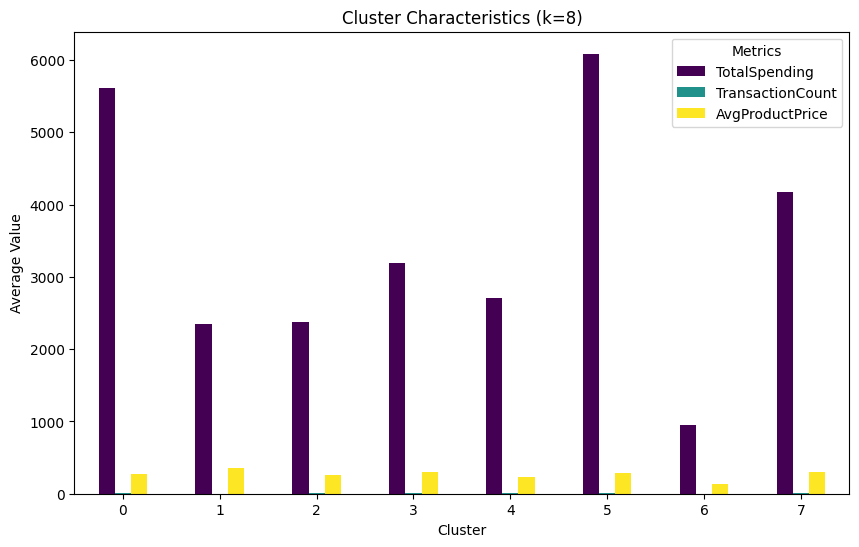

In [120]:
# Bar plot for cluster characteristics
cluster_analysis[['TotalSpending', 'TransactionCount', 'AvgProductPrice']].plot(
    kind='bar', figsize=(10, 6), colormap='viridis'
)
plt.title('Cluster Characteristics (k=8)')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.show()


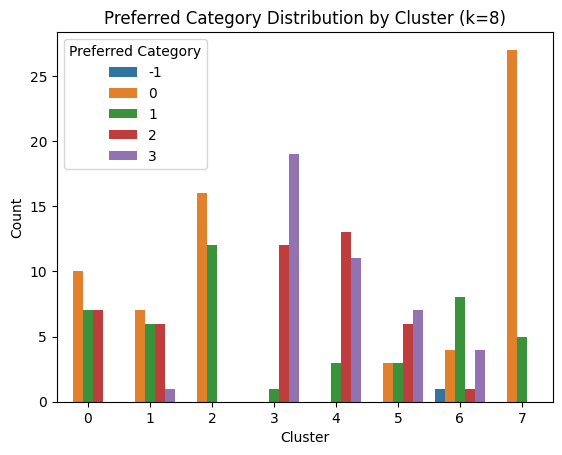

In [121]:
import seaborn as sns

# Preferred category distribution
sns.countplot(
    data=customer_data, x='Cluster', hue='PreferredCategory', palette='tab10'
)
plt.title('Preferred Category Distribution by Cluster (k=8)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Preferred Category')
plt.show()
